<a href="https://colab.research.google.com/github/birajaghoshal/OCT_Fluid_Segmentation/blob/main/Multi_Class_Segmentation_OCT_V1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Image Segmentation goal:** To take either a RGB color image (heightxwidthx3) or a grayscale image (heightxwidthx1) and output a segmentation map where each pixel contains a class label.

**Background:** Optical coherence tomography (OCT) is one of the most commonly used ophthalmic diagnostic techniques. Macular Edema (ME) is the swelling of the macular region in the eye. Segmentation of the fluid region in the retinal layer is an important step in detecting lesions. However, manual segmentation is often a time consuming and subjective process. 

**Our goal:** Automatic fluid segmentation in retinal optical coherence tomography images (OCT). This work presents a automated method based on deep learning algorithms and convolutional neural network (CNN) to segment and detect two types of fluid including sub-retinal fluid (SRF) and intra-retinal fluid (IRF).

**Important points to note:** The important property of IRF and SRF is that these fluid types stem from abnormal blood vessels leakage from the choroidal and retinal vasculature, and the resultant dark region and IRF and SRF are located between inner limiting membrane (ILM) and retinal pigment epithelium (RPE) layers.

**Ideal Methodology:**
Step 1. The segmentation of ILM and RPE layers as a ROI for IRF and SRF regions. This step is very important due (i) the background region is very similar to fluid/cyst regions in both brightness and texture. This can easily mislead the CNN segmentation method since this method is based on
brightness of neighboring pixels of target pixel and (ii) ROI segmentation is speeding up since the ROI is processed instead of the whole image. [Alternatively we can use get_random_snippets function for patch based input to CNN]

Step 2. IRF and SRF segmentation are modeled as a supervised classification task in which fluid IRF and SRF are labeled as 0 and 1, respectively. Therefore, a CNN is trained for multi-Class classification. Note: IPF and SRF fluid types are classified as different fluid type otherwise we can consider binary classification (fluid vs tissue pixels).

Step 3. The regions between these layers are input to a convolutional neural network (CNN). CNN training can be modifired by using Transfer learning, by various types of NN architecture (UNet, UNet++, DeepVLab, DoUNet, ADC-Net etc.), image generator keras, and different loss fuctons etc.

In [1]:
path = ""
from google.colab import drive, files
#from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:

import tensorflow as tf
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 
import pandas as pd
from datetime import datetime 

from sklearn.metrics import f1_score, roc_auc_score

In [3]:
import skimage.restoration as sr
import numpy as np
import glob
import h5py
import os
import scipy.io as scio
from skimage import exposure
from skimage.io import imsave, imread
#from scipy.misc import imresize
#from medpy.filter.noise import immerkaer
from scipy.io import savemat
from scipy import ndimage, misc
import matplotlib.pyplot as plt
%matplotlib inline
import re

hval = 10
alpha = 15
beta = 1

def denoiseImage(image):
    maxvalue = np.max(image)
    newimage = image*(255.0/maxvalue).astype(np.uint8)
    denoised = sr.denoise_nl_means(newimage, multichannel=False, h=hval)
    denoised = denoised - (alpha*beta)
    denoised[denoised<0]=0
    denoised = denoised.astype(np.uint8)
    #denoisedimages.append(denoised)
    return denoised

In [4]:
IMG_WIDTH = 512
IMG_HEIGHT = 1024
IMG_CHANNELS = 1 # grayscale images

# paths to image folders (train, test)
train_images_path='/content/drive/My Drive/App/MoorfieldsInnovationLab/SegmentationAssignment/sample/oct'
train_masks_path_irf='/content/drive/My Drive/App/MoorfieldsInnovationLab/SegmentationAssignment/sample/irf/'
train_masks_path_srf='/content/drive/My Drive/App/MoorfieldsInnovationLab/SegmentationAssignment/sample/srf/'


In [5]:
import os
from keras.preprocessing import image
import pylab
%matplotlib inline

img_size = (160, 160)
num_classes = 3
batch_size = 32

oct_images_path = sorted(
    [
        os.path.join(train_images_path, fname)
        for fname in os.listdir(train_images_path)
        if fname.endswith(".png")
    ]
)
mask_irf_img_paths = sorted(
    [
        os.path.join(train_masks_path_irf, fname)
        for fname in os.listdir(train_masks_path_irf)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

mask_srf_img_paths = sorted(
    [
        os.path.join(train_masks_path_srf, fname)
        for fname in os.listdir(train_masks_path_srf)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of OCT samples:", len(oct_images_path))
print("Number of IRF samples:", len(mask_irf_img_paths))
print("Number of SRF samples:", len(mask_srf_img_paths))

#for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
#    print(input_path, "|", target_path)

Number of OCT samples: 167
Number of IRF samples: 167
Number of SRF samples: 167


In [6]:
#We would need a channel for each IPF and SPF. We can read the masks as numpy arrays and concatenate them along the channels axis
#Effectively to create a single numpy array of shape (width, height, 2).

#Segmentation network should also output a mask of shape (width, height, 2) with activation function as softmax for the last layer 
#in case of Multi-Class segmentation

#We can experiment with various loss functions instead of cross entropy. For multi-class segmentation, we can try:
#generalized dice loss
#dice loss (summed across all classes)
#categorical focal loss
#boundary loss

# We can try with multiple networks e.g.: ReLayNet, DeepLabv3, SegNet etc.

#Alternateive we can use Multi-Label Classifition (this is more practical)


In [7]:
def combine_masks(tresh=1e-2):
    import skimage.io as sio
    import skimage
    from skimage.morphology import disk, rectangle, closing, opening, binary_closing, convex_hull_image
    from skimage.filters.rank import entropy
    from PIL import Image
    from PIL import ImageFilter

    MASK_PATH_SRF ='/content/drive/My Drive/App/MoorfieldsInnovationLab/SegmentationAssignment/sample/'
    MASK_PATH_IRF ='/content/drive/My Drive/App/MoorfieldsInnovationLab/SegmentationAssignment/sample/irf/'

    #print (DATA_ROOT)
    image_names = list()
    for subdir, dirs, files in os.walk(MASK_PATH_SRF + 'srf'):
        for file in files:
            #print(file)
            filepath = subdir + os.sep + file
            print("file", filepath)
            if filepath.endswith(".png"):
                image_name = filepath.split('/')[-1]
                image_names.append([filepath, image_name])
                print(image_name)

    for filepath, image_name in image_names:
        # print filepath, image_name
        im_mask_srf = sio.imread(filepath)
        im_mask_irf = sio.imread(MASK_PATH_IRF + image_name)
        # add masks
        result = 255*(im_mask_srf + im_mask_irf)
        result = result.clip(0, 255).astype("uint8")

        plt.imshow(result, cmap='gray')
        plt.pause(.1)

        mask_slice_ = Image.fromarray((result * 255).astype('uint8'), mode='L')
        save_name = '/content/drive/My Drive/App/MoorfieldsInnovationLab/SegmentationAssignment/sample/processed/masks/' + image_name
        mask_slice_.save(save_name)

#combine_masks(tresh=1e-2)

In [8]:
def create_roi_masks(tresh=1e-2):
    import skimage.io as sio
    import skimage
    from skimage.morphology import disk, rectangle, closing, opening, binary_closing, convex_hull_image
    from skimage.filters.rank import entropy
    from PIL import Image
    from PIL import ImageFilter

    DATA_ROOT ='/content/drive/My Drive/App/MoorfieldsInnovationLab/SegmentationAssignment/sample/'
    MASK_PATH_IRF ='/content/drive/My Drive/App/MoorfieldsInnovationLab/SegmentationAssignment/sample/processed/masks/'

    #print (DATA_ROOT)
    image_names = list()
    for subdir, dirs, files in os.walk(DATA_ROOT + 'oct'):
        for file in files:
            #print(file)
            filepath = subdir + os.sep + file
            print("file", filepath)
            if filepath.endswith(".png"):
                image_name = filepath.split('/')[-1]
                image_names.append([filepath, image_name])
                #print(image_name)

    for filepath, image_name in image_names:
        # print filepath, image_name
        img = sio.imread(filepath)
        im_mask = sio.imread(MASK_PATH_IRF + image_name)
        im_mask = im_mask.astype(np.int8)
        im_slice = skimage.img_as_float(img.astype(np.float32) / 128. - 1.)

        im_slice_ = entropy(im_slice, disk(15))
        im_slice_ = im_slice_ / (np.max(im_slice_) + 1e-16)
        im_slice_ = np.asarray(im_slice_ > tresh, dtype=np.int8)
        im_slice_ = np.bitwise_or(im_slice_,im_mask)
        selem = disk(55)
        im_slice_ = binary_closing(im_slice_, selem=selem)

        h, w = im_slice_.shape
        rnge = list()
        for x in range(0, w):
            col = im_slice_[:, x]
            col = np.nonzero(col)[0]
            # print col, col.shape
            if len(col) > 0:
                y_min = np.min(col)
                y_max = np.max(col)
                rnge.append(int((float(y_max) - y_min)/h*100.))
                im_slice_[y_min:y_max, x] = 1
        if len(rnge) > 0:
            print (image_name, np.max(rnge))
        else:
            print (image_name, "**************")

        plt.imshow(im_slice, cmap='gray')
        #plt.imshow(im_slice_, cmap='jet', alpha=0.5)
        plt.pause(.1)

        #im_slice_ = Image.fromarray((im_slice_ * 255).astype('uint8'), mode='L')
        im_slice_ = Image.fromarray(im_slice_, mode='L')
        save_name = DATA_ROOT + 'processed/roi_oct/' + image_name
        im_slice_.save(save_name)

#create_roi_masks(tresh=1e-2)

In [25]:
from keras.preprocessing import image
import pylab
%matplotlib inline
import skimage.io as sio
import skimage
from skimage.morphology import disk, rectangle, closing, opening, binary_closing, convex_hull_image
from skimage.filters.rank import entropy
from PIL import Image
from PIL import ImageFilter

IMG_WIDTH_HEIGHT = 256
IMG_CHANNELS = 3
classes = 3

X = np.zeros((len(oct_images_path), IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT, 3), dtype=np.float32)
Y = np.zeros((len(oct_images_path), IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT, 1), dtype=np.uint8)

#OCT_PATH_Processed ='/content/drive/My Drive/App/MoorfieldsInnovationLab/SegmentationAssignment/sample/processed/'

OCT_PATH ='/content/drive/My Drive/App/MoorfieldsInnovationLab/SegmentationAssignment/sample/'
MASK_PATH ='/content/drive/My Drive/App/MoorfieldsInnovationLab/SegmentationAssignment/sample/processed/masks/'

#print (DATA_ROOT)
image_names = list()
for subdir, dirs, files in os.walk(OCT_PATH + 'oct'):
    for file in files:
        #print(file)
        filepath = subdir + os.sep + file
        #print("file", filepath)
        if filepath.endswith(".png"):
            image_name = filepath.split('/')[-1]
            image_names.append([filepath, image_name])
            #print(image_name)

X = list()
for filepath, image_name in image_names:
    # print filepath, image_name
    #img = sio.imread(filepath)
    img = image.load_img(filepath, grayscale=False,target_size=(IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT)) #imread(img_path)[:,:,:3] #.astype("float32") #/ 255.0 -> is done by rgb2gray
    img = image.img_to_array(img)
    img = img.astype('float32') / 255.0
    X.append(img)    
   
X = np.array(X)


In [28]:
from keras.preprocessing import image
import pylab
%matplotlib inline

IMG_WIDTH_HEIGHT = 256
IMG_CHANNELS = 3
classes = 3

Y_irf = np.zeros((len(oct_images_path), IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT, 1), dtype=np.uint8)
Y_srf = np.zeros((len(oct_images_path), IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT, 1), dtype=np.uint8)
Y = np.zeros((len(oct_images_path), IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT, 1), dtype=np.uint8)

oct_images_path = sorted(
    [
        os.path.join(train_images_path, fname)
        for fname in os.listdir(train_images_path)
        if fname.endswith(".png")
    ]
)
mask_irf_img_paths = sorted(
    [
        os.path.join(train_masks_path_irf, fname)
        for fname in os.listdir(train_masks_path_irf)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

mask_srf_img_paths = sorted(
    [
        os.path.join(train_masks_path_srf, fname)
        for fname in os.listdir(train_masks_path_srf)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

for i in range(len(oct_images_path)):
        
    irf_mask_path = mask_irf_img_paths[i]
    mask = image.load_img(irf_mask_path, grayscale=True,target_size=(IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT)) #imread(img_path)[:,:,:3] #.astype("float32") #/ 255.0 -> is done by rgb2gray
    mask = image.img_to_array(mask)   
    Y_irf[i] = mask

    srf_mask_path = mask_srf_img_paths[i]
    mask = image.load_img(srf_mask_path, grayscale=True,target_size=(IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT)) #imread(img_path)[:,:,:3] #.astype("float32") #/ 255.0 -> is done by rgb2gray
    mask = image.img_to_array(mask)    
    Y_srf[i] = mask

mask = np.stack([Y_irf, Y_srf], axis=-1)
print(mask.shape)
Y=mask.reshape(mask.shape[0],mask.shape[1],mask.shape[2],mask.shape[4])
print(Y.shape)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


(167, 256, 256, 2)


In [ ]:
print(X.shape)
print(Y.shape)

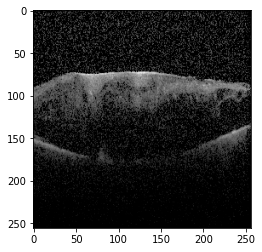

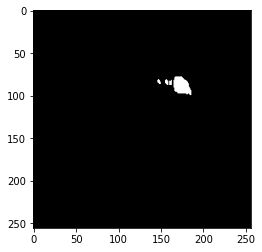

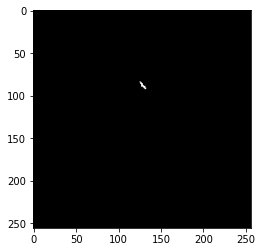

In [29]:
from google.colab.patches import cv2_imshow

i = 114 #111

from matplotlib import pyplot as plt
plt.imshow(X[i])
plt.show()

plt.imshow(Y[i,:,:,0], cmap='gray')
plt.show()

plt.imshow(Y[i,:,:,1], cmap='gray')
plt.show()


In [31]:
train_test_split = int(len(X)*0.8)
x_train = X[:train_test_split]
y_train = Y[:train_test_split]
x_test = X[train_test_split:]
y_test = Y[train_test_split:]

In [32]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(133, 256, 256, 3)
(133, 256, 256, 2)
(34, 256, 256, 3)
(34, 256, 256, 2)


In [33]:
#X_train, Y_train = get_random_snippets(x_train, y_train, number=200, size=(128,128))
#X_test, Y_test = get_random_snippets(x_test, y_test, number=1000, size=(128,128))
X_train, Y_train, X_test, Y_test = x_train, y_train, x_test, y_test

print('X_train shape: ', X_train.shape)
print('Y_train shape: ', Y_train.shape)
print('X_test shape: ', X_test.shape)
print('Y_test shape: ', Y_test.shape)

X_train shape:  (133, 256, 256, 3)
Y_train shape:  (133, 256, 256, 2)
X_test shape:  (34, 256, 256, 3)
Y_test shape:  (34, 256, 256, 2)


<Figure size 1440x1440 with 0 Axes>

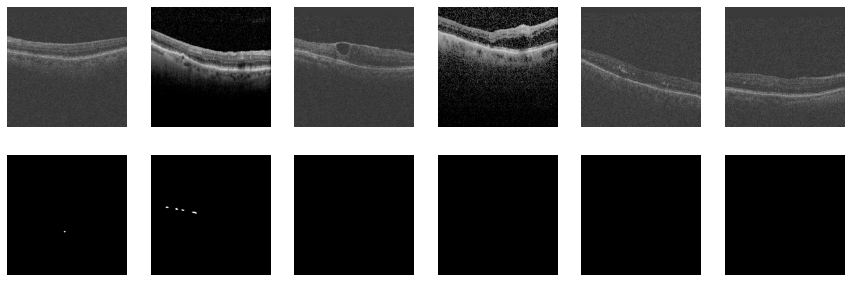

In [34]:
plt.rcParams['figure.figsize'] = [15, 5]
M=6
list_index = np.random.randint(low=0, high=X_train.shape[0], size=M)
plt.figure(figsize=(20,20))
fig, ax = plt.subplots(2,M)
for k, ind in enumerate(list_index):
    ax[0,k].imshow(X_train[ind])
    ax[1,k].imshow(Y_train[ind,:,:,0], cmap='gray')
    
    ax[0,k].axis('off')
    ax[1,k].axis('off')


In [35]:
from keras.layers import *

def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [36]:
from tensorflow.keras.applications.resnet50 import ResNet50
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)

#model.summary()

In [37]:
"""
Automated Dispersion Compensation Network (ADC-Net).
This file contains the network architecture of ADC-Net. All functions and dependencies are self-contained
@author: dleninja
"""
#
from tensorflow.keras.layers import Input, Conv2D, ZeroPadding2D, BatchNormalization, UpSampling2D, Concatenate, Activation, AveragePooling2D, MaxPool2D
from tensorflow.keras import Model
from tensorflow.keras import backend
import sys

def adcnet_model(block=[6, 12, 24, 16], height=None, width=None, n_channels=3):
	"""
	ADC-Net model is an encoder-decoder network.
	- The encoder is based on the DenseNet-121 architecture.
	- The decoder is a custom a decoder.
	Args:
		blocks: number of blocks for the four dense layers
		input_size: shape tuple, if specified, should not be smaller than 32.
		n_channels: number of magnitude channels
	Returns:
		Model of network.
	"""
	input_size = (height, width, n_channels)
	#
	bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1
	inputs = Input(input_size, name="Input_Layer")
	x = ZeroPadding2D(padding=(3,3), name="conv1_zeropad1")(inputs)
	x = Conv2D(filters=64, kernel_size=7, strides=2, use_bias=False, padding="valid", name="conv1_conv")(x)
	x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name="conv1_bn")(x)
	x0 = Activation("relu", name="conv1_relu")(x)
	x = ZeroPadding2D(padding=(1,1), name="conv1_zeropad2")(x0)
	x = MaxPool2D(pool_size=3, strides=2, name="pool1")(x)
	#
	x = dense_block(x, block[0], name="conv2")
	[x, x1] = transition_block(x, 0.5, name="pool2")
	x = dense_block(x, block[1], name="conv3")
	[x, x2] = transition_block(x, 0.5, name="pool3")
	x = dense_block(x, block[2], name="conv4")
	[x, x3] = transition_block(x, 0.5, name="pool4")
	x = dense_block(x, block[3], name="conv5")
	#
	x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name="bn")(x)
	x = Activation("relu", name='relu')(x)
	#
	x = UpSampling2D(size=(2,2))(x)
	x = decoder_block(x, x3, 256, name="decode1")
	x = UpSampling2D(size=(2,2))(x)
	x = decoder_block(x, x2, 128, name="decode2")
	x = UpSampling2D(size=(2,2))(x)
	x = decoder_block(x, x1, 64, name="decode3")
	x = UpSampling2D(size=(2,2))(x)
	x = decoder_block(x, x0, 32, name="decode4")
	#
	x = UpSampling2D(size=(2,2))(x)
	x = Conv2D(filters=16, kernel_size=3, strides=1,  use_bias=False, padding="same", name="decoder_conv1_conv")(x)
	x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name="decoder_conv1_bn")(x)
	x = Activation("relu", name="decoder_conv1_relu")(x)
	x = Conv2D(filters=16, kernel_size=3, strides=1,  use_bias=False, padding="same", name="decoder_conv2_conv")(x)
	x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name="decoder_conv2_bn")(x)
	x = Activation("relu", name="decoder_conv2_relu")(x)
	#
	x = Conv2D(filters=1, kernel_size=(1,1), strides=1, use_bias=True, padding="same", name="final_conv")(x)
	#outputs = Activation("sigmoid", name="output_classification")(x)
	outputs = Conv2D(2, 1, padding="same", activation="softmax")(x)
  #outputs = Activation("softmax", name="output_classification")(x)

	#
	adcnet = Model(inputs, outputs)
	#
	return adcnet

def dense_block(x, blocks, name):
	"""
	Densely connected blocks
	Args:
		x: input tensor.
		blocks: integer, the number of conv blocks.
		name: string, block label.
	Returns:
		x: Output tensor for the block.
	"""
	for i in range(blocks):
		x = conv_block(x, 32, name=name + "_block" + str(i + 1))
	
	return x

def transition_block(x, reduction, name):
	"""
	Transition Block
	Args:
		x: input tensor.
		reduction: float, compression rate at transition layers.
		name: string, block label.
	Returns:
		x1: Output tensor for the block.
		x2: Conv2D output tensor for skip-connection with the decoder
	"""
	bn_axis = 3 if backend.image_data_format() == "channels_last" else 1
	x1 = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + "_bn")(x)
	x1 = Activation('relu', name=name + "_relu")(x1)
	x2 = Conv2D(filters=int(backend.int_shape(x)[bn_axis]*reduction), kernel_size=1, use_bias=False, name=name + "_conv")(x1)
	x1 = AveragePooling2D(2, strides=2, name=name + "_pool")(x2)

	return x1, x2

def decoder_block(x, x1, growth_rate, name):
	"""
	Decoder Block
	Args:
		x: input tensor 1, tensor from previous upsampled layer.
		x1: input tensor 2, tensor from corresponding layer in the encoder.
		growth_rate: float, growth rate for decoder block.
		name: string, block name.
	Returns:
		x2: Output tensor for the block.
	"""
	bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1
	x2 = Concatenate(axis=bn_axis, name=name + "_concat")([x, x1])
	#
	x2 = Conv2D(filters=growth_rate, kernel_size=3, use_bias=False, padding="same", name=name + '_0_conv')(x2)
	x2 = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + "_0_bn")(x2)
	x2 = Activation("relu", name=name + '_0_relu')(x2)
	#
	x2 = Conv2D(filters=growth_rate, kernel_size=3,  use_bias=False, padding="same", name=name + '_1_conv')(x2)
	x2 = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + "_1_bn")(x2)
	x2 = Activation("relu", name=name + '_1_relu')(x2)

	return x2

def conv_block(x, growth_rate, name):
	"""
	Building block for the Dense block.
	Args:
		x: input tensor.
		growth_rate: float, growth rate at dense layers.
		name: string, block label.
	Returns:
		x2: Output tensor for the block.
	"""
	bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1
	x1 = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + "_0_bn")(x)
	x1 = Activation("relu", name=name + '_0_relu')(x1)
	#
	x1 = Conv2D(filters=4*growth_rate, kernel_size=1, use_bias=False, name=name + '_1_conv')(x1)
	x1 = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + "_1_bn")(x1)
	x1 = Activation("relu", name=name + '_1_relu')(x1)
	#
	x1 = Conv2D(filters=growth_rate, kernel_size=3, use_bias=False, padding="same", name=name + "_2_conv")(x1)
	x2 = Concatenate(axis=bn_axis, name=name + "_concat")([x, x1])

	return x2

#
#model = adcnet_model(block=[6, 12, 24, 16], height=256, width=256, n_channels=3)
#
"""
Import the DenseNet121 pre-trained weights from the ImageNet dataset into the encoder of ADCNet
"""
#
"""
densenet_model = tf.keras.applications.DenseNet121(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    )

weights = [layer.get_weights() for layer in densenet_model.layers[5:427]]
for layer, weight in zip(model.layers[5:427], weights):
    layer.set_weights(weight)

"""
#Compile the Model, dependent on the loss function defined
#
#

'\ndensenet_model = tf.keras.applications.DenseNet121(\n    include_top=True,\n    weights="imagenet",\n    input_tensor=None,\n    input_shape=None,\n    pooling=None,\n    classes=1000,\n    )\n\nweights = [layer.get_weights() for layer in densenet_model.layers[5:427]]\nfor layer, weight in zip(model.layers[5:427], weights):\n    layer.set_weights(weight)\n\n'

In [38]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

def conv_block(inputs, filters, pool=True):
    x = Conv2D(filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if pool == True:
        p = MaxPool2D((2, 2))(x)
        return x, p
    else:
        return x

def build_unet(shape, num_classes):
    inputs = Input(shape)

    """ Encoder """
    x1, p1 = conv_block(inputs, 16, pool=True)
    x2, p2 = conv_block(p1, 32, pool=True)
    x3, p3 = conv_block(p2, 48, pool=True)
    x4, p4 = conv_block(p3, 64, pool=True)

    """ Bridge """
    b1 = conv_block(p4, 128, pool=False)

    """ Decoder """
    u1 = UpSampling2D((2, 2), interpolation="bilinear")(b1)
    c1 = Concatenate()([u1, x4])
    x5 = conv_block(c1, 64, pool=False)

    u2 = UpSampling2D((2, 2), interpolation="bilinear")(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, 48, pool=False)

    u3 = UpSampling2D((2, 2), interpolation="bilinear")(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, 32, pool=False)

    u4 = UpSampling2D((2, 2), interpolation="bilinear")(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, 16, pool=False)

    """ Output layer """
    output = Conv2D(num_classes, 1, padding="same", activation="softmax")(x8)

    return Model(inputs, output)


model = build_unet((256, 256, 3), 2)
#model.summary()


In [39]:
# In future, we can improve this by using image generator keras functions.
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
#from tensorflow.keras.applications.resnet50 import ResNet50

""" Seeding """
np.random.seed(42)
#tf.random.set_seed(42)

""" Dataset """
path = "/content/drive/My Drive/App/MoorfieldsInnovationLab/target/"

""" Hyperparameters """
shape = (256, 256, 3)
num_classes = 2
lr = 1e-4
batch_size = 8
epochs = 50

# Specify the evaluation metrics
metrics = {'f1_score': f1_score, 'auroc': roc_auc_score}

""" Model """
#model = build_unet(shape, num_classes)
#model = VGGSegnet(256, num_classes)
#model = build_vgg16_unet(shape, num_classes, True)
#model = DeeplabV3Plus(image_size=256, num_classes=2)
#model = adcnet_model(block=[6, 12, 24, 16], height=256, width=256, n_channels=3)

model.compile(loss="categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(lr),
              metrics = ["acc"]
             )

train_steps = len(X_train)//batch_size
valid_steps = len(X_test)//batch_size

callbacks = [
    ModelCheckpoint("/content/drive/My Drive/App/MoorfieldsInnovationLab/target/model.h5", verbose=1, save_best_model=True),
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=10, verbose=1)
]

history = model.fit(X_train, Y_train,
    steps_per_epoch=train_steps,
    validation_split=0.2,
    epochs=epochs,
    callbacks=callbacks
)


Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 0.4619 - acc: 0.0264
Epoch 1: saving model to /content/drive/My Drive/App/MoorfieldsInnovationLab/target/model.h5
16/16 [==============================] - 85s 5s/step - loss: 0.4619 - acc: 0.0264 - val_loss: 0.2061 - val_acc: 0.0013 - lr: 1.0000e-04
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 0.3832 - acc: 0.0275
Epoch 2: saving model to /content/drive/My Drive/App/MoorfieldsInnovationLab/target/model.h5
16/16 [==============================] - 82s 5s/step - loss: 0.3832 - acc: 0.0275 - val_loss: 0.2183 - val_acc: 2.4697e-04 - lr: 1.0000e-04
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 0.3549 - acc: 0.0368
Epoch 3: saving model to /content/drive/My Drive/App/MoorfieldsInnovationLab/target/model.h5
16/16 [==============================] - 84s 5s/step - loss: 0.3549 - acc: 0.0368 - val_loss: 0.2344 - val_acc: 2.4697e-04 - lr: 1.0000e-04
Epoch 4/50
16/16 [====================

In [ ]:
from keras import models
#model = keras.models.load_model("/content/drive/My Drive/App/MoorfieldsInnovationLab/target/model.h5")
##############################################################
import random
test_img_number = 112 #112 #114 #random.randint(0, len(X_train))
test_img = X_train[test_img_number]
ground_truth=Y_train[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_pred_unet = model.predict(test_img_input) 

test_prediction_unet = np.argmax(test_pred_unet, axis=3)[0,:,:]

plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(222)
plt.title('Testing Label - IPF')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(223)
plt.title('Result')
plt.imshow(1-test_prediction_unet, cmap='gray')
plt.subplot(224)
plt.title('Testing Label - SPF')
plt.imshow(ground_truth[:,:,1], cmap='gray')

plt.show()

In [ ]:
for i  in range (X_test.shape[0]):
    print ("----Image: ----------------", i)
    test_img = X_train[i]
    ground_truth=Y_train[i]
    test_img_input=np.expand_dims(test_img, 0)
    test_pred_unet = model.predict(test_img_input) 
    test_prediction_unet = np.argmax(test_pred_unet, axis=3)[0,:,:]

    plt.figure(figsize=(8, 8))
    plt.subplot(221)
    plt.title('Testing Image')
    plt.imshow(test_img[:,:,0], cmap='gray')
    plt.subplot(222)
    plt.title('Testing Label - IPF')
    plt.imshow(ground_truth[:,:,0], cmap='gray')
    plt.subplot(223)
    plt.title('DeepVlab result')
    plt.imshow(test_prediction_unet, cmap='gray')
    plt.subplot(224)
    plt.title('Testing Label - SPF')
    plt.imshow(ground_truth[:,:,1], cmap='gray')
    print ("--------------------")
    plt.show()

In [ ]:
break;